In [ ]:
from google.colab import drive
import os
import pandas as pd
import yfinance as yf
import numpy as npition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.dates import DateFormatter
from scipy.stats import skew
from hmmlearn.hmm import GaussianHMM
plt.style.use("seaborn-v0_8")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/My Drive/market-regime-forecasting'
os.chdir(project_path)

In [ ]:
print(os.getcwd())

/content/drive/My Drive/market-regime-forecasting


## Loading data

In [ ]:
DATA_DIR = Path("../History")
csv_files = sorted(DATA_DIR.glob("*.csv"))
len(csv_files)

In [ ]:
frames = []

for fp in tqdm(csv_files, desc="Reading 15-min bars"):
    ticker = fp.stem.upper()

    df = (
        pd.read_csv(fp,
                    usecols=["timestamp", "close"],
                    parse_dates=["timestamp"],
                    infer_datetime_format=True)
          .rename(columns={"close": ticker})
          .set_index("timestamp")
    )

    df[ticker] = df[ticker].astype("float32")
    frames.append(df)

prices = (
    pd.concat(frames, axis=1)
      .sort_index()
      .loc[lambda x: ~x.index.duplicated(keep="first")]
)

prices.info(memory_usage="deep")
prices.head()

In [ ]:
parquet_path = DATA_DIR.parent / "all_prices.parquet"
prices.to_parquet(parquet_path, engine="pyarrow", compression="zstd")

print(f"Saved tidy dataset → {parquet_path}")

In [ ]:
prices = pd.read_parquet('all_prices.parquet')

We identify and rank the worst tickers by their longest consecutive streak of missing values, in order to later exclude them and prevent excessive row loss when computing returns and dropping NaNs.


In [ ]:
# drop hopeless tickers
def max_nan_streak(s):
    return (
        s.isna().astype(int)
          .groupby(s.notna().cumsum())
          .sum().max()
    )

cov      = prices.notna().mean()             # % bars observed
streak   = prices.apply(max_nan_streak)      # longest consecutive NaNs
BARS_DAY = 26

bad = cov[cov < 0.60].index.union(           # <60 % history
      streak[streak > BARS_DAY*5].index)     # ≥1 week missing
prices15 = prices.drop(columns=bad)
print(f" Dropped {len(bad)} tickers – {prices.shape[1]} remain")

 Dropped 49 tickers – 163 remain


#  Down-sample to one row per trading day

In [434]:
#  daily close-to-close returns
prices_d  = prices15.resample("1D").last().dropna(how="all")
returns_d = np.log(prices_d).diff().dropna(how="any")

prices_d.to_parquet("prices_daily.parquet")
returns_d.to_parquet("returns_daily.parquet")


In [435]:
returns_d.shape

(1740, 163)

## Add macro & cross-section features

In [439]:
# daily macro series
yf_tickers = {
    "^VIX":  "VIX",        # implied vol
    "DX-Y.NYB": "USD_Index",  # dollar strength
    "^IRX":  "TBill_13w",  # 3-month Treasury yield
    "^TNX":  "TNote_10y",  # 10-year yield
    "GLD":   "Gold",       # gold ETF
    "USO":   "Oil",        # crude proxy
    "XLK":   "Tech_ETF",   # sector ETFs give risk-on/off flavour
    "XLF":   "Fin_ETF",
    "XLU":   "Util_ETF",
}

macro = ( yf.download(list(yf_tickers), start=returns_d.index[0].date(),
                      end=returns_d.index[-1].date(), interval="1d",
                      progress=False)["Close"]
            .rename(columns=yf_tickers)
            .reindex(returns_d.index).ffill() )

In [437]:
macro.head()

Ticker,USD_Index,Gold,Oil,Fin_ETF,Tech_ETF,Util_ETF,TBill_13w,TNote_10y,VIX
timestamp,,,,,,,,,
2015-12-02,99.989998,100.690002,99.839996,16.613159,39.354267,31.015881,0.200,2.178,15.910000
2015-12-09,97.349998,102.639999,92.480003,16.220510,38.925625,31.317207,0.245,2.208,19.610001
2015-12-10,97.940002,102.550003,90.959999,16.234045,39.032787,30.802738,0.230,2.239,19.340000
2015-12-11,97.570000,103.110001,88.559998,15.875246,38.220154,30.714533,0.213,2.139,24.389999
2015-12-14,97.599998,101.790001,89.279999,15.909097,38.514854,30.868870,0.198,2.225,22.730000


In [440]:
# PCA factors on the cross-section of returns
pca  = PCA(n_components=5, random_state=0).fit(returns_d)
pcs  = pd.DataFrame(pca.transform(returns_d), index=returns_d.index,
                    columns=[f"PC{i+1}" for i in range(5)])

In [441]:
pcs.head()

,PC1,PC2,PC3,PC4,PC5
timestamp,,,,,
2015-12-02,0.149051,-0.074893,0.011662,0.017262,0.031969
2015-12-09,0.167158,0.049569,0.111972,-0.079648,-0.031296
2015-12-10,-0.032540,-0.103531,-0.033523,0.083325,-0.005349
2015-12-11,0.427084,-0.003097,0.013620,0.003012,-0.022856
2015-12-14,0.016833,-0.162519,0.028491,0.036494,0.182922


In [442]:
# cross-sectional features
disp = returns_d.std(axis=1).rename("CrossDisp1d")
PctUp        = (returns_d > 0).mean(axis=1).rename("PctUp")
MeanMinusMed = (returns_d.mean(axis=1) - returns_d.median(axis=1)).rename("MeanMinusMed")
AbsDisp      = returns_d.abs().mean(axis=1).rename("AbsDisp")
CSSkew       = returns_d.apply(skew, axis=1).rename("CSSkew")
Top5Share    = ((returns_d.gt(returns_d.quantile(0.95, axis=1), axis=0).sum(axis=1) /returns_d.shape[1]).rename("Top5Share"))

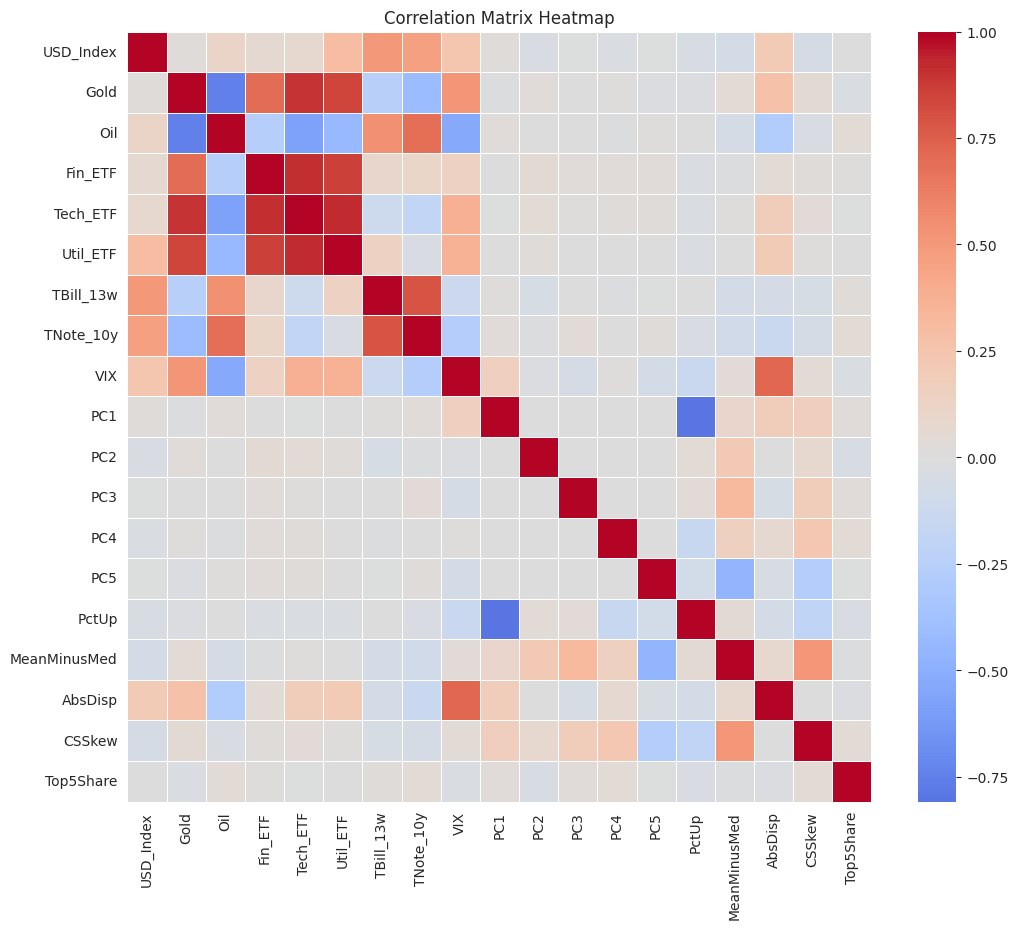

        Feature 1     Feature 2  Correlation
66       Tech_ETF      Util_ETF     0.919011
51        Fin_ETF      Tech_ETF     0.910034
20           Gold      Tech_ETF     0.900478
52        Fin_ETF      Util_ETF     0.865431
21           Gold      Util_ETF     0.846432
130           PC1         PctUp    -0.808344
93      TBill_13w     TNote_10y     0.791479
18           Gold           Oil    -0.750855
123           VIX       AbsDisp     0.723427
19           Gold       Fin_ETF     0.698474
39            Oil     TNote_10y     0.683377
36            Oil      Tech_ETF    -0.576051
38            Oil     TBill_13w     0.546717
40            Oil           VIX    -0.535641
24           Gold           VIX     0.518846
166  MeanMinusMed        CSSkew     0.508285
5       USD_Index     TBill_13w     0.500608
6       USD_Index     TNote_10y     0.468681
157           PC5  MeanMinusMed    -0.466291
37            Oil      Util_ETF    -0.430418


In [444]:
# daily macro series
yf_tickers = {
    "^VIX":  "VIX",        # implied vol
    "DX-Y.NYB": "USD_Index",  # dollar strength
    "^IRX":  "TBill_13w",  # 3-month Treasury yield
    "^TNX":  "TNote_10y",  # 10-year yield
    "GLD":   "Gold",       # gold ETF
    "USO":   "Oil",        # crude proxy
    "XLK":   "Tech_ETF",   # sector ETFs give risk-on/off flavour
    "XLF":   "Fin_ETF",
    "XLU":   "Util_ETF",
}

macro = ( yf.download(list(yf_tickers), start=returns_d.index[0].date(),
                      end=returns_d.index[-1].date(), interval="1d",
                      progress=False)["Close"]
            .rename(columns=yf_tickers)
            .reindex(returns_d.index).ffill() )

# PCA factors on the cross-section of returns
pca  = PCA(n_components=5, random_state=0).fit(returns_d)
pcs  = pd.DataFrame(pca.transform(returns_d), index=returns_d.index,
                    columns=[f"PC{i+1}" for i in range(5)])

# cross-sectional features
disp = returns_d.std(axis=1).rename("CrossDisp1d")
PctUp        = (returns_d > 0).mean(axis=1).rename("PctUp")
MeanMinusMed = (returns_d.mean(axis=1) - returns_d.median(axis=1)).rename("MeanMinusMed")
AbsDisp      = returns_d.abs().mean(axis=1).rename("AbsDisp")
CSSkew       = returns_d.apply(skew, axis=1).rename("CSSkew")
Top5Share    = ((returns_d.gt(returns_d.quantile(0.95, axis=1), axis=0).sum(axis=1) /returns_d.shape[1]).rename("Top5Share"))


features_d = pd.concat([macro,pcs, PctUp, MeanMinusMed, AbsDisp, CSSkew, Top5Share],axis=1).dropna()

corr_matrix=features_d.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Unstack and filter self-correlations
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Sort by absolute correlation
top_corr = corr_pairs.reindex(corr_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Display top 20 most correlated pairs
print(top_corr.head(20))


# 20-day vol-of-vol on SPY
spy = "SPY" if "SPY" in returns_d.columns else returns_d.columns[0]
vol20 = returns_d[spy].rolling(20).std()
volofvol = vol20.rolling(20).std().rename("VolOfVol20d")

features_d = pd.concat([features_d,volofvol], axis=1).dropna()

features_d["MktRet"] = returns_d["SPY"]

spy = "SPY" if "SPY" in returns_d.columns else returns_d.columns[0]

features_ext = features_d.copy()
features_ext["RollRet20d"] = returns_d[spy].rolling(20).sum()
realised20   = returns_d[spy].rolling(20).std()
features_ext["VIXDivRV"]   = features_d["VIX"] / realised20
features_ext = features_ext.dropna()

In [445]:
features_d = pd.concat([macro,pcs, PctUp, MeanMinusMed, AbsDisp, CSSkew, Top5Share],axis=1).dropna()


In [446]:
features_d

,USD_Index,Gold,Oil,Fin_ETF,Tech_ETF,Util_ETF,TBill_13w,TNote_10y,VIX,PC1,PC2,PC3,PC4,PC5,PctUp,MeanMinusMed,AbsDisp,CSSkew,Top5Share
timestamp,,,,,,,,,,,,,,,,,,,
2015-12-02,99.989998,100.690002,99.839996,16.613159,39.354267,31.015881,0.200,2.178,15.910000,0.149051,-0.074893,0.011662,0.017262,0.031969,0.208589,0.000619,0.014375,0.200513,0.055215
2015-12-09,97.349998,102.639999,92.480003,16.220510,38.925625,31.317207,0.245,2.208,19.610001,0.167158,0.049569,0.111972,-0.079648,-0.031296,0.325153,0.001363,0.014582,0.697310,0.055215
2015-12-10,97.940002,102.550003,90.959999,16.234045,39.032787,30.802738,0.230,2.239,19.340000,-0.032540,-0.103531,-0.033523,0.083325,-0.005349,0.478528,-0.000357,0.011339,-0.732139,0.055215
2015-12-11,97.570000,103.110001,88.559998,15.875246,38.220154,30.714533,0.213,2.139,24.389999,0.427084,-0.003097,0.013620,0.003012,-0.022856,0.220859,0.004286,0.027383,2.793190,0.055215
2015-12-14,97.599998,101.790001,89.279999,15.909097,38.514854,30.868870,0.198,2.225,22.730000,0.016833,-0.162519,0.028491,0.036494,0.182922,0.460123,-0.005132,0.015594,-2.294871,0.055215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-05,105.040001,170.520004,64.779999,33.318241,119.110680,64.820877,4.498,3.720,22.459999,0.143010,-0.165109,0.266141,-0.050465,0.029553,0.312883,-0.000115,0.019771,-1.830729,0.055215
2023-01-06,103.879997,173.710007,64.830002,34.059505,122.600067,66.124748,4.493,3.569,21.129999,-0.331856,-0.033119,0.018354,-0.097751,0.025042,0.883436,-0.002945,0.024903,-1.762921,0.055215
2023-01-09,103.000000,174.100006,65.879997,33.934357,124.025314,66.571785,4.483,3.517,21.969999,-0.098680,0.121629,-0.048592,0.023907,0.006355,0.650307,0.002870,0.014924,1.104101,0.055215


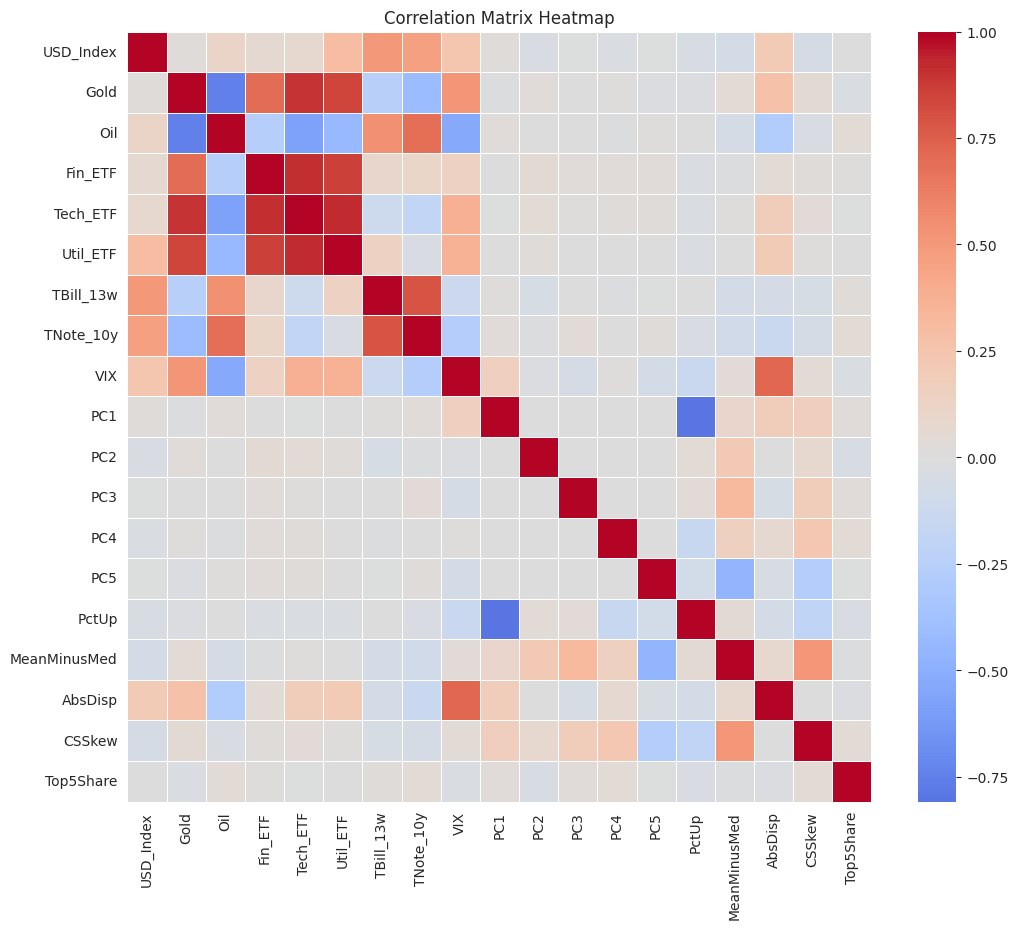

In [447]:
corr_matrix=features_d.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [448]:
# Unstack and filter self-correlations
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Sort by absolute correlation
top_corr = corr_pairs.reindex(corr_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Display top 20 most correlated pairs
print(top_corr.head(20))

        Feature 1     Feature 2  Correlation
66       Tech_ETF      Util_ETF     0.919011
51        Fin_ETF      Tech_ETF     0.910034
20           Gold      Tech_ETF     0.900478
52        Fin_ETF      Util_ETF     0.865431
21           Gold      Util_ETF     0.846432
130           PC1         PctUp    -0.808344
93      TBill_13w     TNote_10y     0.791479
18           Gold           Oil    -0.750855
123           VIX       AbsDisp     0.723427
19           Gold       Fin_ETF     0.698474
39            Oil     TNote_10y     0.683377
36            Oil      Tech_ETF    -0.576051
38            Oil     TBill_13w     0.546717
40            Oil           VIX    -0.535641
24           Gold           VIX     0.518846
166  MeanMinusMed        CSSkew     0.508285
5       USD_Index     TBill_13w     0.500608
6       USD_Index     TNote_10y     0.468681
157           PC5  MeanMinusMed    -0.466291
37            Oil      Util_ETF    -0.430418


In [449]:
# we drop Util_ETF, Fin_ETF, PctUp
features_d=features_d.drop(columns=["Util_ETF","Fin_ETF","PctUp"])

In [ ]:

# 20-day vol-of-vol on SPY
spy = "SPY" if "SPY" in returns_d.columns else returns_d.columns[0]
vol20 = returns_d[spy].rolling(20).std()
volofvol = vol20.rolling(20).std().rename("VolOfVol20d")

features_d = pd.concat([features_d,volofvol], axis=1).dropna()


In [ ]:
features_d.columns

Index(['USD_Index', 'Gold', 'Oil', 'Tech_ETF', 'TBill_13w', 'TNote_10y', 'VIX',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'MeanMinusMed', 'AbsDisp', 'CSSkew',
       'Top5Share', 'VolOfVol20d'],
      dtype='object')

In [ ]:
features_d

,USD_Index,Gold,Oil,Tech_ETF,TBill_13w,TNote_10y,VIX,PC1,PC2,PC3,PC4,PC5,MeanMinusMed,AbsDisp,CSSkew,Top5Share,VolOfVol20d
timestamp,,,,,,,,,,,,,,,,,
2016-02-09,96.070000,113.580002,65.440002,34.777355,0.300,1.729,26.540001,0.128252,-0.106484,-0.042337,0.099286,0.091855,-0.002900,0.016422,-0.624243,0.055215,0.000656
2016-02-10,95.889999,114.459999,63.680000,34.831196,0.298,1.705,26.290001,-0.024091,-0.024813,0.071211,-0.049577,-0.057771,0.002896,0.011619,0.913608,0.055215,0.000528
2016-02-11,95.559998,119.059998,63.919998,34.759396,0.273,1.644,28.139999,0.198039,-0.089493,-0.051444,-0.026241,-0.171889,0.000409,0.021535,0.984974,0.055215,0.000502
2016-02-12,95.980003,118.360001,66.639999,35.244026,0.270,1.748,25.400000,-0.321961,0.013439,0.089210,-0.061199,-0.048209,-0.000053,0.023605,-0.034856,0.055215,0.000527
2016-02-16,96.870003,114.769997,66.480003,35.872272,0.273,1.778,24.110001,-0.382069,-0.143979,-0.058872,0.134544,0.108072,-0.005695,0.030303,-0.630806,0.055215,0.000564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-05,105.040001,170.520004,64.779999,119.110680,4.498,3.720,22.459999,0.143010,-0.165109,0.266141,-0.050465,0.029553,-0.000115,0.019771,-1.830729,0.055215,0.001501
2023-01-06,103.879997,173.710007,64.830002,122.600075,4.493,3.569,21.129999,-0.331856,-0.033119,0.018354,-0.097751,0.025042,-0.002945,0.024903,-1.762921,0.055215,0.001214
2023-01-09,103.000000,174.100006,65.879997,124.025299,4.483,3.517,21.969999,-0.098680,0.121629,-0.048592,0.023907,0.006355,0.002870,0.014924,1.104101,0.055215,0.000925


In [ ]:
features_d["MktRet"] = returns_d["SPY"]

In [ ]:
features_d.columns

Index(['USD_Index', 'Gold', 'Oil', 'Tech_ETF', 'TBill_13w', 'TNote_10y', 'VIX',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'MeanMinusMed', 'AbsDisp', 'CSSkew',
       'Top5Share', 'VolOfVol20d', 'MktRet'],
      dtype='object')

In [ ]:
spy = "SPY" if "SPY" in returns_d.columns else returns_d.columns[0]

features_ext = features_d.copy()
features_ext["RollRet20d"] = returns_d[spy].rolling(20).sum()
realised20   = returns_d[spy].rolling(20).std()
features_ext["VIXDivRV"]   = features_d["VIX"] / realised20
features_ext = features_ext.dropna()


In [ ]:
features_ext

,USD_Index,Gold,Oil,Tech_ETF,TBill_13w,TNote_10y,VIX,PC1,PC2,PC3,PC4,PC5,MeanMinusMed,AbsDisp,CSSkew,Top5Share,VolOfVol20d,MktRet,RollRet20d,VIXDivRV
timestamp,,,,,,,,,,,,,,,,,,,,
2016-02-09,96.070000,113.580002,65.440002,34.777355,0.300,1.729,26.540001,0.128252,-0.106484,-0.042337,0.099286,0.091855,-0.002900,0.016422,-0.624243,0.055215,0.000656,-0.002543,-0.034857,1923.381271
2016-02-10,95.889999,114.459999,63.680000,34.831196,0.298,1.705,26.290001,-0.024091,-0.024813,0.071211,-0.049577,-0.057771,0.002896,0.011619,0.913608,0.055215,0.000528,-0.000485,-0.040948,1919.720567
2016-02-11,95.559998,119.059998,63.919998,34.759396,0.273,1.644,28.139999,0.198039,-0.089493,-0.051444,-0.026241,-0.171889,0.000409,0.021535,0.984974,0.055215,0.000502,-0.011716,-0.030109,2158.105218
2016-02-12,95.980003,118.360001,66.639999,35.244026,0.270,1.748,25.400000,-0.321961,0.013439,0.089210,-0.061199,-0.048209,-0.000053,0.023605,-0.034856,0.055215,0.000527,0.017945,-0.029640,1942.559004
2016-02-16,96.870003,114.769997,66.480003,35.872272,0.273,1.778,24.110001,-0.382069,-0.143979,-0.058872,0.134544,0.108072,-0.005695,0.030303,-0.630806,0.055215,0.000564,0.015969,0.006846,1880.254239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-05,105.040001,170.520004,64.779999,119.110680,4.498,3.720,22.459999,0.143010,-0.165109,0.266141,-0.050465,0.029553,-0.000115,0.019771,-1.830729,0.055215,0.001501,-0.010772,-0.032536,1925.736429
2023-01-06,103.879997,173.710007,64.830002,122.600075,4.493,3.569,21.129999,-0.331856,-0.033119,0.018354,-0.097751,0.025042,-0.002945,0.024903,-1.762921,0.055215,0.001214,0.021610,-0.008602,1655.476510
2023-01-09,103.000000,174.100006,65.879997,124.025299,4.483,3.517,21.969999,-0.098680,0.121629,-0.048592,0.023907,0.006355,0.002870,0.014924,1.104101,0.055215,0.000925,-0.000232,-0.016932,1742.860951


# EDA Regime Intuition

In [ ]:
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 110

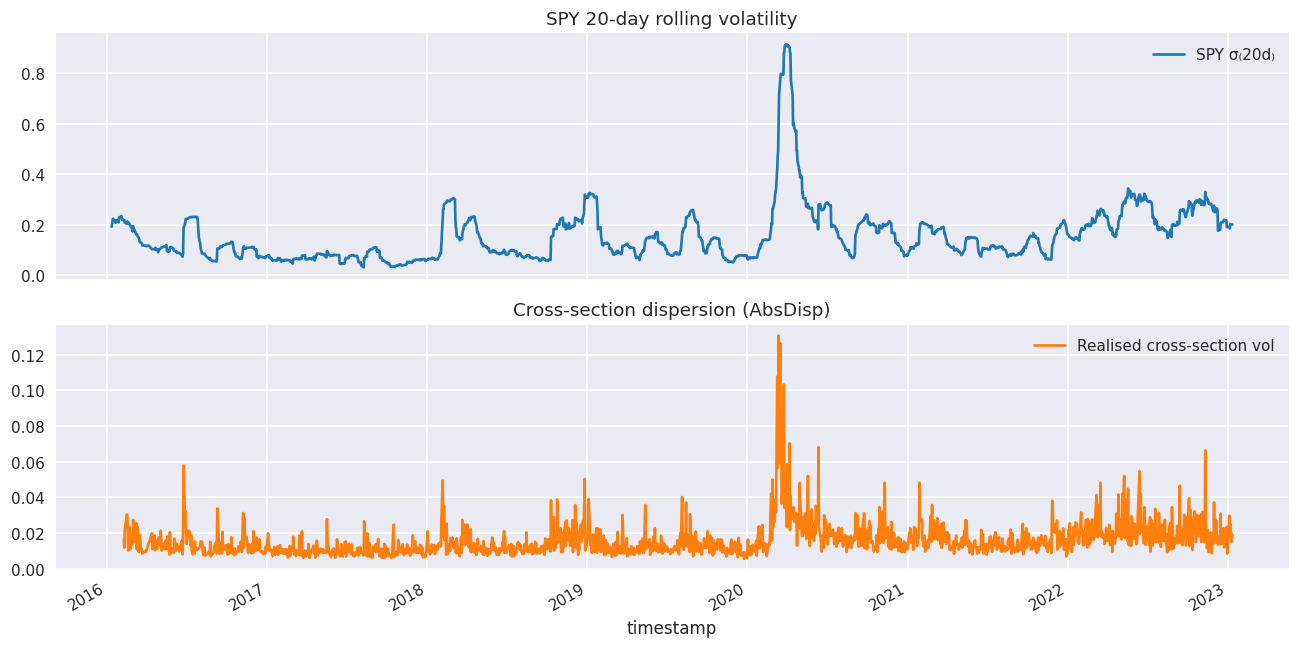

In [ ]:
win = 20
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Rolling volatility (annualised)
rolling_vol = returns_d["SPY"].rolling(win).std() * np.sqrt(252)
rolling_vol.plot(ax=ax[0], color="tab:blue", label=f"SPY σ₍{win}d₎")
ax[0].set_title(f"SPY {win}-day rolling volatility")
ax[0].legend()

# Cross-sectional dispersion (AbsDisp)
features_d["AbsDisp"].plot(ax=ax[1], color="tab:orange", label="Realised cross-section vol")
ax[1].set_title("Cross-section dispersion (AbsDisp)")
ax[1].legend()

plt.tight_layout()
plt.show()


The SPY’s 20-day rolling volatility spiked sharply during early 2020, reflecting the COVID-19 market shock.  
This period also saw the highest cross-sectional dispersion, indicating significant divergence in stock returns across the market.


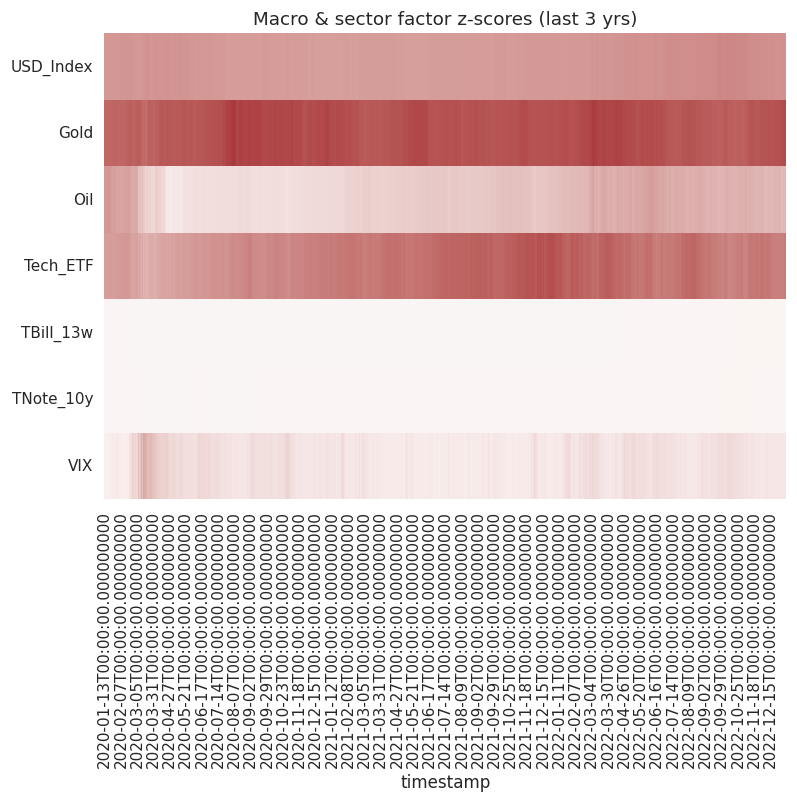

In [ ]:
macro_cols = ["USD_Index","Gold","Oil","Tech_ETF","TBill_13w","TNote_10y","VIX"]
macro_last = features_d[macro_cols].tail(3*252)        # ~3 years
sns.heatmap(macro_last.T, cmap="vlag", center=0, cbar=False,
            yticklabels=macro_cols)
plt.title("Macro & sector factor z-scores (last 3 yrs)"); plt.show()


Gold and Tech_ETF show sustained positive z-scores, indicating persistent strength or investor preference.  
In contrast, TBill_13w and TNote_10y remain near zero, suggesting limited variation in recent short and long rates.


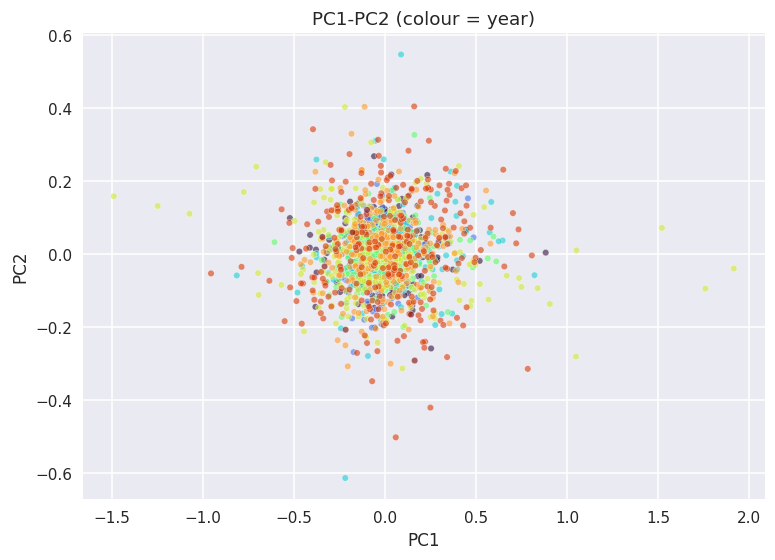

In [ ]:
pcs2 = features_d[["PC1","PC2"]].copy()
pcs2["Year"] = pcs2.index.year
sns.scatterplot(data=pcs2, x="PC1", y="PC2", hue="Year",
                palette="turbo", s=18, alpha=.6, legend=False)
plt.title("PC1-PC2 (colour = year)"); plt.show()


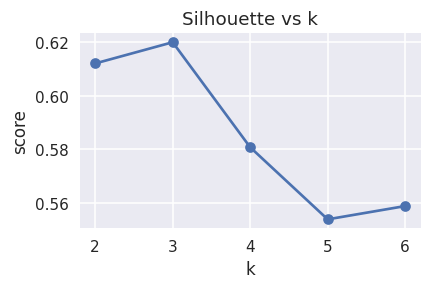

{2: np.float64(0.6120191632324291), 3: np.float64(0.6199134958574578), 4: np.float64(0.58081601825926), 5: np.float64(0.5539918949551829), 6: np.float64(0.5589340775297422)}


In [ ]:
X_sil = features_d[["PC1","PC2","AbsDisp","VIX"]].values
scores = {}
for k in range(2,7):
    lab = KMeans(k, n_init=20, random_state=0).fit_predict(X_sil)
    scores[k] = silhouette_score(X_sil, lab)

plt.figure(figsize=(4,2.3))
plt.plot(list(scores), list(scores.values()), marker="o")
plt.title("Silhouette vs k"); plt.xlabel("k"); plt.ylabel("score"); plt.show()
print(scores)


The silhouette analysis suggests that clustering financial regimes into 2 or 3 groups yields the best-defined structure.  
This indicates the presence of distinct market environments (e.g. Bully, Risky, Bear) in the selected factor space.


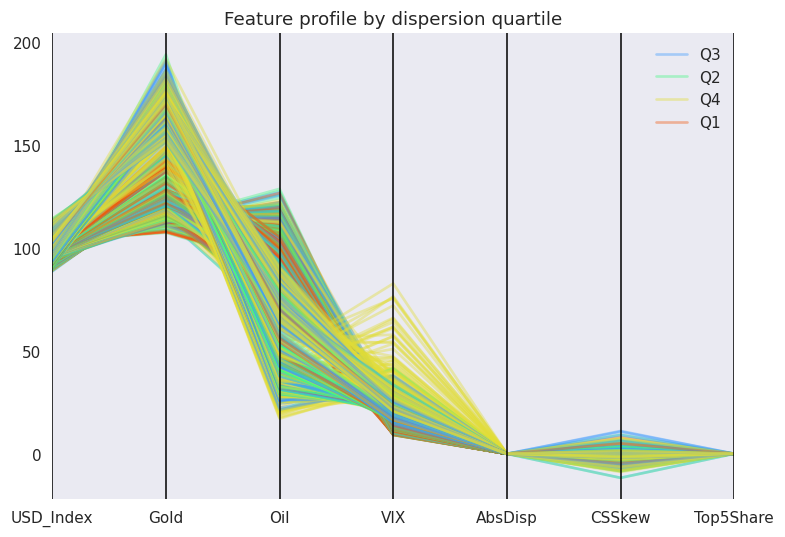

In [ ]:
tmp = features_d.copy()
tmp["DispBucket"] = pd.qcut(features_d["AbsDisp"], 4, labels=["Q1","Q2","Q3","Q4"])
plot_cols = ["USD_Index","Gold","Oil","VIX","AbsDisp","CSSkew","Top5Share"]
from pandas.plotting import parallel_coordinates
parallel_coordinates(tmp.reset_index()[["DispBucket"]+plot_cols],
                     "DispBucket",
                     color=sns.color_palette("turbo",4), alpha=.4)
plt.title("Feature profile by dispersion quartile"); plt.show()

The feature profile shows that higher cross-sectional dispersion (Q4) tends to coincide with elevated VIX, Oil, and macro uncertainty.  
As dispersion increases, asymmetry (CSSkew) and concentration (Top5Share) also vary, suggesting shifts in sentiment and leadership dynamics.


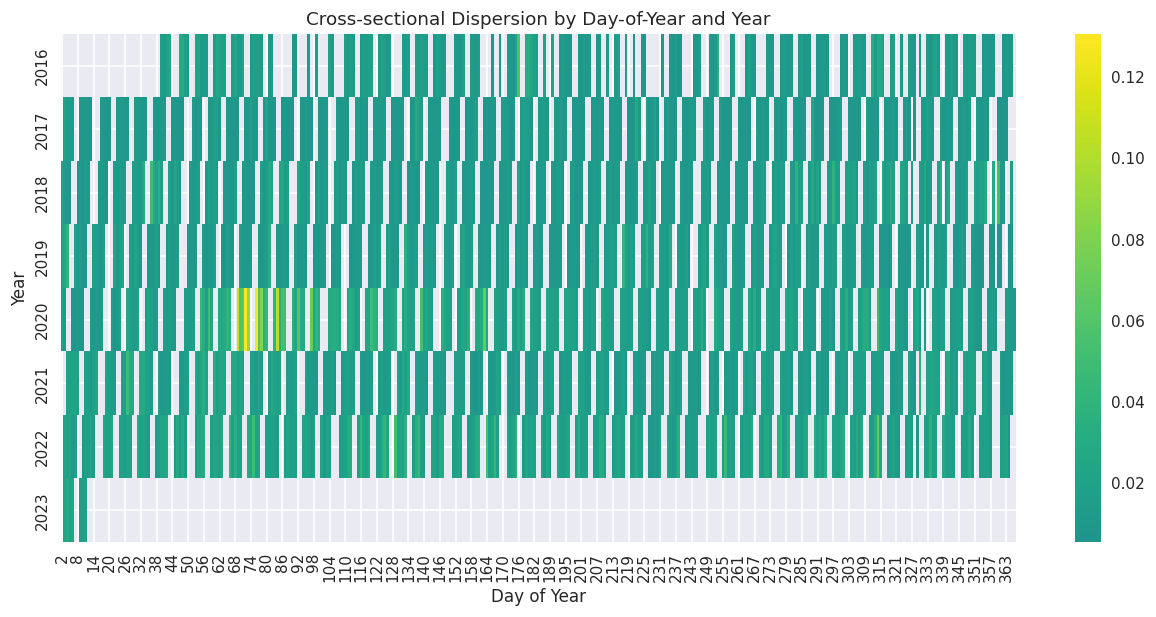

In [ ]:
disp = features_d["AbsDisp"].copy()
disp.index = pd.to_datetime(disp.index)

df_disp = disp.to_frame(name="AbsDisp")
pivot = df_disp.pivot_table(values="AbsDisp",index=df_disp.index.year,columns=df_disp.index.dayofyear)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="viridis", center=0)
plt.title("Cross-sectional Dispersion by Day-of-Year and Year")
plt.xlabel("Day of Year")
plt.ylabel("Year")
plt.show()

This heatmap reveals temporal patterns in cross-sectional dispersion across years and calendar days.  
Notably, spikes in 2020 highlight heightened market dislocations (COVID shock), while seasonal dispersion appears relatively stable otherwise.


## Regime Detection using Hidden Markov Model

In [452]:
spy ="SPY"

# ---------- 1 · macro series -----------------------------------------------
yf_tickers = {
    "^VIX":"VIX",
    "DX-Y.NYB":"USD_Index",
    "^IRX":"TBill_13w",
    "^TNX":"TNote_10y",
    "GLD":"Gold",
    "USO":"Oil",
    "XLK":"Tech_ETF",
    "XLF":"Fin_ETF",
    "XLU":"Util_ETF"
}

macro = (
    yf.download(list(yf_tickers), start=returns_d.index[0].date(),
                end  =returns_d.index[-1].date(), interval="1d", progress=False)["Close"]
      .rename(columns=yf_tickers)
      .reindex(returns_d.index).ffill()
)

# ---------- 2 · PCA factors -------------------------------------------------
pca = PCA(n_components=5, random_state=0).fit(returns_d)
pcs = pd.DataFrame(pca.transform(returns_d),
                   index=returns_d.index, columns=[f"PC{i+1}" for i in range(5)])

# ---------- 3 · cross-section metrics --------------------------------------
disp         = returns_d.std(axis=1).rename("CrossDisp1d")
pct_up       = (returns_d > 0).mean(axis=1).rename("PctUp")
mean_minus   = (returns_d.mean(axis=1) - returns_d.median(axis=1)).rename("MeanMinusMed")
abs_disp     = returns_d.abs().mean(axis=1).rename("AbsDisp")
cs_skew      = returns_d.apply(skew, axis=1).rename("CSSkew")
top5_share   = (returns_d.gt(returns_d.quantile(0.95, axis=1), axis=0)
                           .sum(axis=1).div(returns_d.shape[1]).rename("Top5Share"))
vol20        = returns_d[spy].rolling(20).std()
vol_of_vol   = vol20.rolling(20).std().rename("VolOfVol20d")

# ---------- 4 · trend & stress features ------------------------------------
roll_ret20   = returns_d[spy].rolling(20).sum().rename("RollRet20d")
vix_div_rv   = (macro["VIX"] / vol20).rename("VIXDivRV")

# ---------- 5 · assemble & drop highly-correlated ---------------------------
features = pd.concat([macro, pcs, disp, pct_up, mean_minus, abs_disp,
                      cs_skew, top5_share, vol_of_vol, roll_ret20, vix_div_rv],
                     axis=1).dropna()


In [458]:
# auto-drop |ρ| > 0.9
corr = features.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.90)]
features = features.drop(columns=to_drop)
print("Dropped (ρ>0.9):", to_drop)
print("Final feature set:", list(features.columns), "\n")

Dropped (ρ>0.9): []
Final feature set: ['USD_Index', 'Gold', 'Oil', 'Fin_ETF', 'TBill_13w', 'TNote_10y', 'VIX', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'CrossDisp1d', 'PctUp', 'MeanMinusMed', 'CSSkew', 'Top5Share', 'VolOfVol20d', 'RollRet20d', 'VIXDivRV'] 



In [459]:

# ---------- 6 · z-score & fit HMM ------------------------------------------
X = (features - features.mean()) / features.std()

hmm = GaussianHMM(n_components=3, covariance_type="diag",
                  n_iter=1000, tol=1e-3, random_state=42).fit(X)
raw  = pd.Series(hmm.predict(X), index=X.index)

means = pd.DataFrame(hmm.means_, columns=X.columns)


In [462]:

tbl = returns_d[spy].groupby(raw).agg(mean="mean", std="std", days="size")
tbl["sharpe"] = np.sqrt(252)*tbl["mean"]/tbl["std"]
print(tbl, "\n")


         mean       std  days    sharpe
0.0  0.001041  0.005986   887  2.761430
1.0  0.001165  0.007782   320  2.376938
2.0 -0.000879  0.019965   495 -0.698574 



In [463]:
tbl = tbl.sort_values("sharpe", ascending=False)
print(tbl, "\n")

         mean       std  days    sharpe
0.0  0.001041  0.005986   887  2.761430
1.0  0.001165  0.007782   320  2.376938
2.0 -0.000879  0.019965   495 -0.698574 



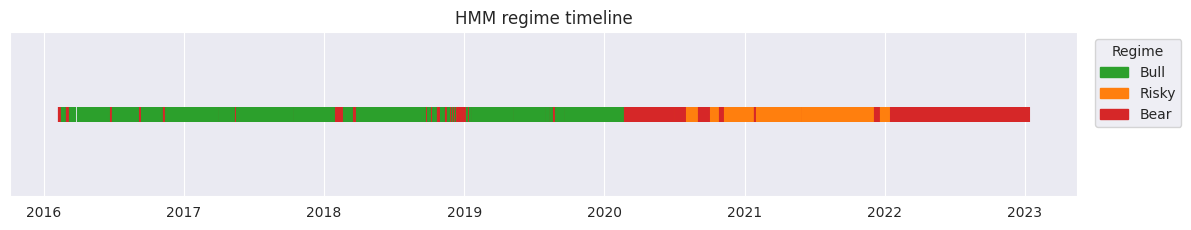

In [467]:
# Step 2: Map state indices to regime names (
mapping = {
    tbl.index[0]: "Bull",     # lowest return
    tbl.index[1]: "Risky",    # middle
    tbl.index[2]: "Bear"      # highest return
}

# Step 3: Apply mapping
regimes = raw.map(mapping).rename("Regime")

# Step 4: Define color map for regimes
color_map = {"Bull": "tab:green", "Risky": "tab:orange", "Bear": "tab:red"}

# Step 5: Plot regime timeline
plt.figure(figsize=(12, 2.4))
plt.scatter(regimes.index, [0]*len(regimes), c=regimes.map(color_map),
            marker="|", s=120)

# Custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=handles, title="Regime", loc="upper left", bbox_to_anchor=(1.01, 1))

plt.title("HMM regime timeline")
plt.yticks([])
plt.tight_layout()
plt.show()


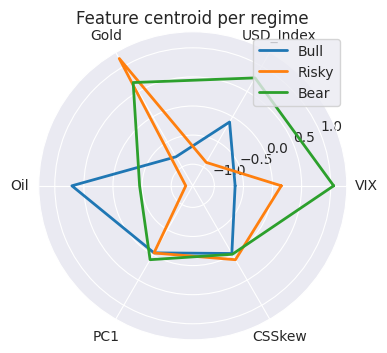

In [469]:
means = pd.DataFrame(hmm.means_, columns=X.columns).assign(Regime=mapping)
plot_cols = ["VIX","USD_Index","Gold","Oil","PC1","CSSkew"]
angles = np.linspace(0, 2*np.pi, len(plot_cols), endpoint=False).tolist()

fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(polar=True)
for _, row in means.iterrows():
    data = row[plot_cols].values
    ax.plot(angles+angles[:1], np.r_[data, data[0]],
            label=row["Regime"], lw=2)
ax.set_xticks(angles); ax.set_xticklabels(plot_cols)
ax.set_title("Feature centroid per regime"); ax.legend(loc="upper right")
plt.show()


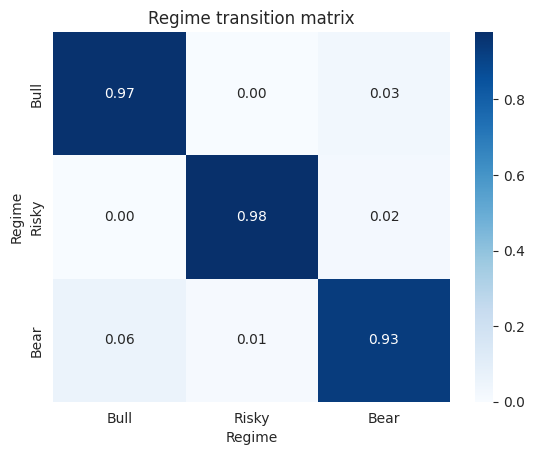

In [470]:
sns.heatmap(pd.DataFrame(hmm.transmat_, index=means["Regime"],
                         columns=means["Regime"]),
            annot=True, cmap="Blues", fmt=".2f")
plt.title("Regime transition matrix"); plt.show()


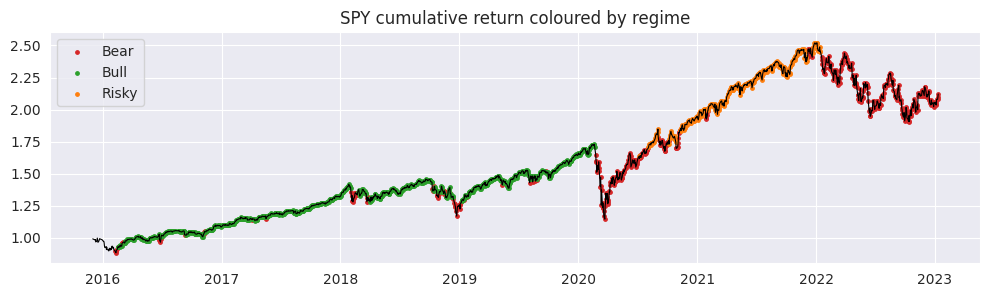

In [471]:
mkt="SPY"
cum = returns_d[mkt].cumsum().apply(np.exp)
plt.figure(figsize=(12,3))
plt.plot(cum, color="black", lw=.8)
for r, grp in regimes.groupby(regimes):
    plt.scatter(grp.index, cum.loc[grp.index],
                color=color_map[r], s=6, label=r)
plt.title(f"{mkt} cumulative return coloured by regime"); plt.legend(); plt.show()


In [472]:
print("State occupancy (days):\n", regimes.value_counts(), "\n")
print("Mean daily return by regime:")
print(returns_d[mkt].groupby(regimes).agg(["mean","std","count"]))

State occupancy (days):
 Regime
Bull     887
Bear     495
Risky    320
Name: count, dtype: int64 

Mean daily return by regime:
            mean       std  count
Regime                           
Bear   -0.000879  0.019965    495
Bull    0.001041  0.005986    887
Risky   0.001165  0.007782    320
